In [1]:
import numpy as np
import matplotlib.pyplot as plt   
from scipy import stats
import os
import random
import pandas as pd
import re
from tvb.simulator.lab import *
import nibabel as nib

sys.path.insert(0, '/home/etienne')
from src import analysis, simulation  # Import analysis for fcd and clustering

remove_roi=[55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
            129, 130,  131,  132,  133,  134,  135,  136,  137,  138,  139,  140, 141, 142, 143,144,145,146,147, 27, 101]

regions=pd.read_csv('modules.csv')
regions["remove_ROI"]=np.isin(regions.index.tolist(),remove_roi)
regions['hemisphere']=['Right']*74 + ['Left']*74

regions108=regions[regions.remove_ROI==False]
regions108.index=np.arange(108)


regions108['hemisphere']=['Right']*54 + ['Left']*54
regionsorg=regions108.sort_values(by=['hemisphere','module'])

/home/etienne/env/src/tvb-library/scientific_library/tvb/datatypes/surfaces.py:61: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)
<ipython-input-1-ff2621cb2e2b>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regions108['hemisphere']=['Right']*54 + ['Left']*54


In [2]:
# Import the anatomical structural connectivity.
pathc='/home/etienne/data/connectivity/'
A148_con = connectivity.Connectivity.from_file(pathc+'Allen_148.zip')
nregions = len(A148_con.weights)     #number of regions
A148_con.speed = np.asarray(np.inf)  #set the conduction speed
np.fill_diagonal(A148_con.weights, 0.)
A148_con.weights = A148_con.weights/np.max(A148_con.weights) #normalization
A148_con.configure()
A148_SC = A148_con.weights

file_refs= nib.load(pathc + 'Vol_148_Allen.nii')

A148= file_refs.get_fdata() 

# ROIs Labels 
with open(pathc+'region_labels.txt') as f:
    content = f.readlines()   # remove whitespace characters like `\n` at the end of each line
ROIs = [ix.strip() for ix in content] 

WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


In [3]:
def go_edge(tseries):
    nregions=tseries.shape[1]
    Blen=tseries.shape[0]
    nedges=int(nregions**2/2-nregions/2)
    iTriup= np.triu_indices(nregions,k=1) 
    gz=stats.zscore(tseries,nan_policy='omit')
    Eseries = gz[:,iTriup[0]]*gz[:,iTriup[1]]
    return Eseries

def edges_str(Bold):
    return(np.sqrt(np.sum(go_edge(Bold)**2,axis=1)))

def Giom_mean(Bold):
    a=edges_str(Bold)
    G=go_edge(Bold)
    Blen=len(a)
    top=G[a>np.percentile(a,95),:]
    dFC=np.corrcoef(top)
    return(np.mean(dFC))
    #return(np.sum(np.abs(a[1:]-a[:Blen-1]))/Blen)

def edges_var(Bold):
    a=edges_str(Bold)
    Blen=len(a)
    return(np.sum(np.abs(a[1:]-a[:Blen-1]))/Blen)  

def varmeangrad(bold):
    Edges=go_edge(bold)
    measure=np.var(np.mean(np.gradient(Edges.T,axis=1),axis=1))
    return(measure)

def meanvargrad(bold):
    Edges=go_edge(bold)
    measure=np.mean(np.var(np.gradient(Edges.T,axis=1),axis=1))
    return(measure)

def edge_to_FC(edge,n=148):
    A=np.zeros((n,n))
    triu=np.triu_indices(n, 1)
    A[triu]=edge
    tril=(triu[1],triu[0])
    A[tril]=edge
    A[np.arange(n),np.arange(n)]=[1]*n
    return(A)

def highest_RSS(bold,p=95):
    RSS=edges_str(bold)
    Edges=go_edge(bold).T
    
    ths=np.percentile(RSS,p)
    timestamp=np.arange(RSS.shape[0])[RSS>ths]
    
    keep=[True]*timestamp.shape[0]
    data=[]
    CAP=[]
    j=0
    for k in timestamp:
        rss=RSS[k]
        #cap=Edges[:,k]
        i=1
        while np.isin(timestamp,k+i).any():
            rss+=RSS[k+i]
            #cap+=Edges[:,k+i]
            timestamp=np.delete(timestamp,np.where(timestamp==k+i))
            keep[j+i]=False
            i+=1
        j+=1
        #cap=cap/i        
        rss=rss/i
        data.append([k,i,rss])
        #CAP.append(cap)
    data=np.array(data)
    #CAP=np.array(CAP)
    return(data[keep])

In [4]:
path='/home/etienne/data/simulation_second_batch/'
path2='/home/etienne/data/dataXetien/'


In [5]:
Blen=2000
nregions=148
file_number=(len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]))
B=np.zeros((Blen,nregions,file_number))
param=np.zeros((file_number,2))
regex = re.compile('\d*\.?\d+')

i=0
for filename in os.listdir(path):
    bold=np.load(path+filename)['Bold_data'][-Blen:,0,:]
    G,N=np.array(regex.findall(filename),dtype='float')[1:]
    B[:,:,i]=bold
    param[i,:]=np.round(G,decimals=3),np.round(N,decimals=3)
    i+=1

In [6]:
data=np.load(path2+'EPI_DMN_A30_CNO_Wt89{}_Baseline.npy'.format(34))
Blen=data.shape[0]
nregions=data.shape[1]-len(remove_roi)
Bemp=np.zeros((8,Blen,nregions))
i=0
for k in [34,36,38,40,41,42,43,44]:
    bold=np.load(path2+'EPI_DMN_A30_CNO_Wt89{}_Baseline.npy'.format(k))
    bold=np.delete(bold,remove_roi,axis=1)
    Bemp[i,:,:]=bold
    i+=1

In [7]:
from scipy.optimize import fsolve,root
from scipy.stats import binom
import cv2

def window(network,delta):
    '''
    Entry: temporal network in the shape nedges x time points
           delta which is the number of time points chosen to average
           
    Return: the unweighted downsampled temporal network of new size (time points)/delta
    '''
    Filter=np.ones((1,delta))

    m=cv2.filter2D(network,-1,Filter)[:,0::delta]
    m[m>0]=1
    return(m)


def Likelihood_activity(a,tau,M):
    #Calculate the set of equation solution of the maximum likelihood estimator with the probability function u(ai,aj)=ai*aj
    
    n=M.shape[0]
    a=a.reshape((n,1))
    amat=np.dot(a,a.T)
    MLmat=(M - tau*amat)/(np.ones((n,n))-amat)
    MLmat[np.eye(n)==1]=0
    F=np.sum(MLmat,1)
    return(F)

def a_init(M,tau):
    #Initialization of the activities of the nodes in order to give to fsolve
    
    n=M.shape[0]
    deg=sum(M,1)/tau
    denom=np.sqrt(np.sum(M)/tau)
    a=np.min([(deg/denom),0.999*np.ones((n))],0)
    return(a)

def backbone(FCbin,tau,alpha=5*1e-2):
    '''
    FCbin is (in principle) the average of the binarized (with a threshold) dFC of one empiric mouse dataset.
    Tau is the number of frames we take into account
    alpha is the confidence level
    
    Gives the most significant edges of the network according to the "Structured backbone of temporal social ties" article technique.
    
    Uses -> Likelihood_activity function to create the function whose root grants the optimal solution
        -> a_init function in order to have a good starting point for the fsolve technique
        -> fsolve function from the scipy.optimize package to find the root of the system of equations
        -> binom.ppf function in order to find the centiles of level alpha and deduce the edges whose activity is higher than expected
        
            -> binom.ppf(cl, n, p) = smallest k such that Prob(X <= k) >= cl, where X is a VA following a binomial distribution of proba p and card n
    '''
    
    cl=1-alpha
    n=FCbin.shape[0]
    
    def func(x):
        return(Likelihood_activity(x,tau=500,M=FCbin))
    
    a_i=a_init(FCbin,500)
    a_opt=fsolve(func,x0=a_i,epsfcn=1e-5)
    a=a_opt.reshape((n,1))
    
    amat=np.dot(a,a.T)      # Probability matrix of the edges (which follows Binomial distribution laws)

    pvalmat=binom.ppf(np.ones(FCbin.shape)*cl,np.ones(FCbin.shape)*tau,amat)     # Calculation of the values to overpass for each edge
    backbone=np.where(FCbin>pvalmat)
    return(backbone)

def jaccard_index(back1,back2):
    '''
    Calculate the Jaccard similarity between two different backbones, which is:
    
    Card(intersection of the backbones)/Card(union of the backbones)
    '''
    Bmat1=np.zeros((n,n))
    Bmat2=np.zeros((n,n))
    Bmat1[back1]=1
    Bmat2[back2]=1

    Bmatint=Bmat1+Bmat2
    jaccard=np.sum(Bmatint>1)/np.sum(Bmatint>0)
    return(jaccard)

def Jac_alt(back1,back2):
    '''
    Modified version of the Jaccard index, where the value calculated is:
    Card(intersection backbones)/min(Card(Backbone1),Card(Backbone2))
    
    It represents how % is the smaller backbone in the bigger backbone
    '''
    
    Bmat1=np.zeros((n,n))
    Bmat2=np.zeros((n,n))
    Bmat1[back1]=1
    Bmat2[back2]=1
    a1=np.sum(Bmat1>0)
    a2=np.sum(Bmat2>0)

    Bmatint=Bmat1+Bmat2
    jaccard=np.sum(Bmatint>1)/np.min([a1,a2])
    return(jaccard)

In [11]:
Backbones=[]
alpha_list=[5e-2,2.5e-2,1e-2,5e-3,2.5e-3,1e-3,5e-4,2.5e-4,1e-4,5e-5,2.5e-5,1e-5,5e-6,2.5e-6,1e-6,5e-7,2.5e-7,1e-7]
factor=9
tau=2000
delta=4
alpha=alpha_list[4]
n=148

for k in range(B.shape[2]):
    B1=B[:,:,k]
    volume=B1.shape[0]
    Edges=go_edge(B1)

    threshold=factor*np.median(np.abs(Edges))
    Edges_bin=np.zeros(shape=Edges.shape)

    Edges_bin[np.abs(Edges)>threshold]=1
    Edges_w=window(Edges_bin.T,delta).T

    FCbin=edge_to_FC(np.sum(Edges_w,0))


    b=backbone(FCbin,np.round(tau/delta),alpha=alpha)
    Backbones.append(b)

In [8]:
alpha_list=[5e-2,2.5e-2,1e-2,5e-3,2.5e-3,1e-3,5e-4,2.5e-4,1e-4,5e-5,2.5e-5,1e-5,5e-6,2.5e-6,1e-6,5e-7,2.5e-7,1e-7]
factor=9
tau=2000
delta=4
alpha=alpha_list[4]
n=148

k=(np.where((param[:,0]==0.57)&(param[:,1]==0.04)))[0][0]

B1=B[:,:,k]
volume=B1.shape[0]
Edges=go_edge(B1)

threshold=factor*np.median(np.abs(Edges))
Edges_bin=np.zeros(shape=Edges.shape)

Edges_bin[np.abs(Edges)>threshold]=1
Edges_w=window(Edges_bin.T,delta).T

FCbin=edge_to_FC(np.sum(Edges_w,0))


b=backbone(FCbin,np.round(tau/delta),alpha=alpha)

In [12]:
blen=[]
for k in range(len(Backbones)):
    blen.append(Backbones[k][0].shape[0])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f425a915ac0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f425a92d160>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f425a915790>],
 'medians': [<matplotlib.lines.Line2D at 0x7f425a92d880>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f425a92dc10>],
 'means': []}

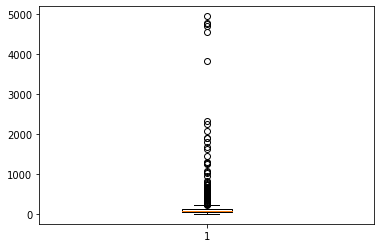

In [13]:
plt.boxplot(blen)

In [14]:
G=0.58
N=0.05

k=(np.where((param[:,0]==G)&(param[:,1]==N)))[0][0]
len(Backbones[k][0])

112

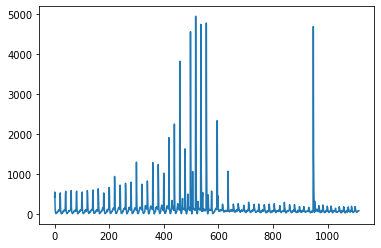

In [15]:
plt.plot(blen)

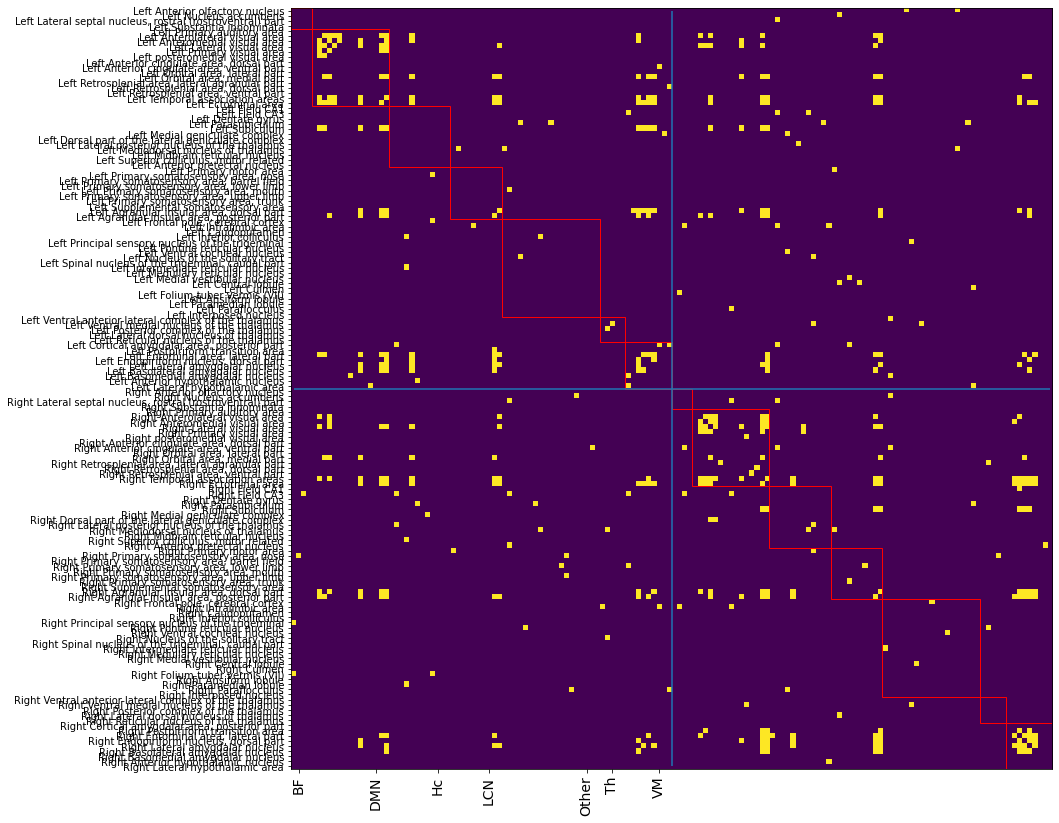

In [36]:
G=0.57
N=0.04

k=(np.where((param[:,0]==G)&(param[:,1]==N)))[0][0]

regions148org=regions.sort_values(by=['hemisphere','module'])

n=148
index=regions148org.index

Bmat=np.zeros((n,n))
Bmat[Backbones[k]]=1
test=Bmat[index,:][:,index]

l=regions148org.groupby('module').nunique().regions/2

plt.figure(figsize=(14,14))
plt.imshow(test)
plt.yticks(range(0, n), regions148org.regions, fontsize=10, rotation=0)
plt.xticks(np.cumsum(l)-3, np.unique(regions148org.module), fontsize=14, rotation=90)

plt.hlines(y=73.5,xmin=0,xmax=147)
plt.vlines(x=73.5,ymin=0,ymax=147)


center=0
for i in range(len(l)):
    rectl=plt.Rectangle((center-0.5,center-0.5),l[i],l[i],fc=(0,0,0,0),ec='red')
    plt.gca().add_patch(rectl)
    rectr=plt.Rectangle((center+73.5,center+73.5),l[i],l[i],fc=(0,0,0,0),ec='red')
    plt.gca().add_patch(rectr)
    center+=l[i]

plt.show()